### Вступление

#### Цели данного ноутбука:
- Поучаствовать в [соревновании](https://www.kaggle.com/competitions/adengi-internship);
- Повторить методы ClassicML (4 месяца не решал классические задачки);
- Получить небольшой практический опыт, используя данные, приближенные к реальным(спасибо ребятам из А-деньги).

#### Description
В этом соревновании вам нужно будет натренировать модель оттока, которая лучше всех сможет генерализовать общую зависимость оттока.

#### Evaluation
Ответы модели будут оценены с помощью F1 метрики между предсказанными ответами и реальными.

#### Первые мысли
По сути стандартная задача бинарной классификаци.

Необходимо предсказать отток клиентов.

В зависимости от кол-ва данных, будем выбирать модель.

Предварительно, как многим известно, в подобных задачах себя очень хорошо зарекомендовали бустинги.
Я взглянул на файлик train.csv, он весит 2.2Гб, данных много, я думаю лучшим решением будут именно бустинги.

Но, т.к. я практикуюсь, мне не важно какой скор я выбью, лично мне важно попробовать разные подходы и поэкспериментировать.

Разумеется в рамках разумных сроков(решаю эту задачу только по выходным).

#### О данных
- monthly_income - среднемесячный заработок клиента (зарплата)
- payment_frequency - частота получения зарплаты (month - 1 раз в месяц, 2 weeks - раз в две недели, и тд)
- status - статус клиента (самозанятый, рабочий, и тд)
- work_experience - кол-во лет стажа клиента
- client_type - тип клиента (новый, повторный)
- settlement - город клиента
- requested_sum - запрашиваемая сумма клиента для займа, если interface - alfa
- region - регион клиента (область, округ, и тд)
- loan_id - уникальный идентификатор займа
- client_id - уникальный идентификатор клиента
- main_agreement_amount - основная одобренная сумма клиенту по займу (может быть больше, чем approved_amount)
- main_agreement_term - основной одобренный срок по займу
- requested_period_days - запрашиваемый срок по займу
- requested_amount - запрашиваемая сумма клиента по займу
- req_app_amount - разница между запрашиваемой суммой займа и одобренной
- approved_amount - одобренная сумма по займу
- source - канал привлечения клиента
- first_source - первый канал привлечения клиента
- period_days - период страховки по займу
- interface - интерфейс, откуда пришла заявка - (site, mobile)
- created_at - дата открытия займа
- type - тип займа (тип продукта)
- closed_at - дата закрытия займа
- days_finish_loan - время в днях, затраченное на закрытие займа (closed_at - created_at)
- gender - пол клиента
- ag - возраст клиента
- repayment_type - Тип комиссии по займу (с 2.5% - with_comission, 5% - with_big_comission, 0% - no_comission)
- loan_order - порядковый номер займа
- have_extension - имеется ли пролонгация по данному займу
- cnt_ext - кол-во пролонгаций по займу
- start_dt - дата начала (список) пролонгаций по займу
- term - срок пролонгации (список)
- price - цена пролонгации (список)
- elecs_sum - штрафы, пени
- recurents_sum - штрафы, пени (там вроде как различия в этапах их начисления)
- tamount - общий кэшфлоу клиента (общая сумма которая была на аккаунте клиента)
- issues - сумма просрочек, штрафов и пени
- principal - сумма основного долга
- interest - прибыль с клиента
- overdue_interest - прибыль с клиента, если есть прослойка
- overdue_fee - штрафы в просрочек
- contact_cases - кол-во обращений клиента с коллекшн
- nbki_score - скор клиента от рисков

- churn - колонка таргета

### Imports

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from category_encoders.cat_boost import CatBoostEncoder

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

### EDA

In [2]:
train = pd.read_csv('./data/train.csv')

 уфффф....
данные прям подгружались несколько секунд, плотненько, в рамках обучения такого не было :D

Теперь. в общем то понятно. почему необходимо изучать Hadoop, Spark и т.д.

Надо посмотреть на них

In [18]:
# посмотрю чутка на данные
pd.set_option('display.max_columns', None)
train[3036207:3036215]

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,days_finish_loan,ag,cnt_ext,term,price,elecs_sum,recurents_sum,tamount,issues,principal,interest,overdue_interest,overdue_fee,nbki_score,payment_frequency,status,loan_id,client_id,source,first_source,interface,type,repayment_type,client_type,settlement,client_type.1,region,gender,loan_order,have_extension,contact_cases,created_at,closed_at,start_dt,churn
3036207,-0.000749,-0.784665,NaN,1.703179,-0.398173,-0.479599,0.798492,-0.020140,1.253061,-0.398173,-0.521161,-1.450319,NaN,NaN,NaN,-0.063933,-0.143015,0.854447,-1.419908,1.419908,-0.452832,-0.218265,-0.185707,-1.497148,2,1,3923361,811926,11,0,0,2,1,1,г Корсаков,repeated,обл Сахалинская,female,10,0,NaN,2024-04-14 06:04:59,2024-05-07 05:55:02,NaN,0
3036208,-0.000752,-1.653445,NaN,-0.761767,-0.340659,0.426103,-1.097626,-0.585785,-0.751240,-0.340659,1.693432,-1.450319,-0.011155,-0.25437,-0.786826,-0.063933,-0.143015,0.036902,0.663348,-0.663348,0.551209,1.521699,-0.185707,-1.393072,2,1,3371773,893529,11,5,2,2,0,1,деревня Пирогово,repeated,Респ Удмуртская,male,21,0,NaN,2024-02-10 19:01:25,2024-02-12 19:41:24,NaN,0
3036209,-0.000752,-1.653445,NaN,-0.836463,0.176974,0.426103,-1.141721,-0.716318,-0.617620,0.176974,2.819184,-1.450319,NaN,NaN,NaN,-0.063933,-0.143015,-0.353018,0.726477,-0.726477,-0.277671,2.183983,3.156060,-1.393072,6,1,5230441,946363,11,11,0,2,1,1,г Октябрьский,repeated,Респ Башкортостан Башкортостан,male,4,0,NaN,2024-09-23 17:53:54,2024-09-25 19:05:41,NaN,1
3036210,-0.000753,NaN,2.653853,-0.537681,-0.340659,NaN,NaN,NaN,-0.751240,-0.340659,6.399443,-1.138691,NaN,NaN,NaN,-0.063933,-0.143015,0.086805,0.473961,-0.473961,-0.240137,4.058721,-0.185707,0.081339,2,1,3937945,985493,11,0,2,2,1,1,село Наровчат,repeated,обл Пензенская,male,3,0,NaN,2024-04-15 18:14:06,2024-05-08 14:03:16,NaN,0
3036211,-0.000747,0.952894,NaN,-0.089509,0.176974,-1.023020,-0.083423,0.153905,-0.350380,0.176974,-0.004422,0.003944,NaN,NaN,NaN,-0.063933,-0.143015,-0.083842,0.095187,-0.095187,0.077655,-0.218265,-0.185707,-0.074775,2,1,4137101,1067977,11,0,2,2,1,1,г Омск,repeated,обл Омская,male,3,0,NaN,2024-05-09 05:46:07,2024-06-07 12:49:26,NaN,1
3036212,-0.000747,0.952894,NaN,0.059882,-0.570718,-1.204160,-0.083423,0.066883,-0.216760,-0.570718,-0.539615,0.003944,NaN,NaN,NaN,-0.063933,-0.143015,-0.155234,-0.031071,0.031071,-0.480357,-0.218265,-0.185707,-0.074775,2,1,2547947,130714,11,11,2,2,1,1,г Каменск-Уральский,repeated,обл Свердловская,female,13,0,NaN,2023-11-04 21:03:51,2023-11-10 10:34:46,NaN,0
3036213,-0.000747,0.952894,NaN,0.059882,0.176974,-0.389028,-0.083423,0.066883,-0.216760,0.176974,-0.521161,0.003944,NaN,NaN,NaN,-0.063933,-0.143015,-0.155234,-0.031071,0.031071,-0.480357,-0.218265,-0.185707,-0.074775,2,1,2425702,168097,11,0,2,2,2,1,г Пенза,repeated,обл Пензенская,male,4,0,NaN,2023-10-22 13:53:21,2023-10-25 21:48:50,NaN,0
3036214,-0.000751,-2.522225,NaN,-0.985854,-0.340659,0.426103,-0.788955,-0.020140,-1.152100,-0.340659,2.653089,-1.034815,NaN,NaN,NaN,-0.063933,-0.143015,-0.562457,0.852735,-0.852735,-0.397781,1.492742,2.178639,-1.367053,2,1,624133,271088,11,0,0,2,3,1,г Екатеринбург,repeated,обл Свердловская,female,4,0,NaN,2023-02-04 07:48:58,2023-02-10 17:38:32,NaN,0


In [20]:
train.shape

(4036207, 45)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 45 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   monthly_income         float64
 1   work_experience        float64
 2   requested_sum          float64
 3   main_agreement_amount  float64
 4   main_agreement_term    float64
 5   requested_period_days  float64
 6   requested_amount       float64
 7   req_app_amount         float64
 8   approved_amount        float64
 9   period_days            float64
 10  days_finish_loan       float64
 11  ag                     float64
 12  cnt_ext                float64
 13  term                   float64
 14  price                  float64
 15  elecs_sum              float64
 16  recurents_sum          float64
 17  tamount                float64
 18  issues                 float64
 19  principal              float64
 20  interest               float64
 21  overdue_interest       float64
 22  overdue_fee       

In [6]:
train.describe()

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,...,source,first_source,interface,type,repayment_type,client_type,loan_order,have_extension,contact_cases,churn
count,4.036000e+06,1.387847e+06,489817.000000,4.036207e+06,4.036207e+06,3.594589e+06,3.621371e+06,3.621371e+06,4.036207e+06,4.036207e+06,...,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,225917.000000,4.036207e+06
mean,-8.252097e-05,1.327124e-04,-0.000607,-1.432715e-04,1.383222e-04,3.266345e-04,-2.585087e-04,-3.261837e-04,7.910522e-05,1.383222e-04,...,8.882859e+00,3.872205e+00,1.570352e+00,1.987750e+00,1.641676e+00,7.609392e-01,5.557003e+00,1.125505e-01,1.506301,2.938724e-01
std,9.431023e-01,9.999002e-01,0.997373,1.000089e+00,1.000341e+00,1.001271e+00,9.997052e-01,9.999505e-01,1.000235e+00,1.000341e+00,...,4.121706e+00,4.846975e+00,7.683009e-01,1.419784e-01,9.512670e-01,4.265100e-01,8.201449e+00,3.160425e-01,1.430518,4.555343e-01
min,-7.560081e-04,-2.522225e+00,-0.592014,-9.858535e-01,-1.145865e+00,-1.657011e+00,-1.318104e+00,-5.241477e+00,-1.152100e+00,-1.145865e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000,0.000000e+00
25%,-7.505928e-04,-7.846654e-01,-0.462179,-6.870721e-01,-3.406587e-01,-3.890285e-01,-8.330511e-01,-6.292957e-01,-7.512400e-01,-3.406587e-01,...,1.100000e+01,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,1.000000,0.000000e+00
50%,-7.488827e-04,8.411442e-02,-0.267427,-3.209154e-01,1.769741e-01,4.261034e-01,-8.342339e-02,-1.071620e-01,-2.167598e-01,1.769741e-01,...,1.100000e+01,0.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,1.000000,0.000000e+00
75%,-7.448212e-04,9.528942e-01,0.057159,5.080537e-01,1.769741e-01,4.261034e-01,1.195353e+00,6.760386e-01,5.181504e-01,1.769741e-01,...,1.100000e+01,1.000000e+01,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,7.000000e+00,0.000000e+00,1.000000,1.000000e+00
max,1.339736e+03,9.528942e-01,5.899720,1.141358e+01,8.804188e+00,1.401163e+01,7.412853e+00,5.636309e+00,9.938363e+00,8.804188e+00,...,1.900000e+01,1.800000e+01,2.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,3.520000e+02,1.000000e+00,64.000000,1.000000e+00


#### База
- База:
    - проверка на дубликаты;
    - обработка пропусков;
    - грамотная обработка категориальных переменных;
    - кодирование категориальных переменных;
    - знакомство с балансом целевой переменной;

##### Проверка на дубликаты

In [19]:
# проверим на пропуски, повторы и т.д.
print(f'Количество дубликатов: {train.duplicated().sum()}')

Количество дубликатов: 0


Хороший дубликат - отсутствующий дубликат

##### Проверка на пропуски

In [17]:
# количество пропущенных значений по фичам:
train.isnull().sum()/len(train)*100

monthly_income            0.005129
work_experience          65.615069
requested_sum            87.864423
main_agreement_amount     0.000000
main_agreement_term       0.000000
requested_period_days    10.941411
requested_amount         10.277867
req_app_amount           10.277867
approved_amount           0.000000
period_days               0.000000
days_finish_loan          0.000000
ag                        0.000000
cnt_ext                  88.760462
term                     88.760462
price                    88.766904
elecs_sum                 0.143551
recurents_sum             0.143551
tamount                   0.043952
issues                    0.000000
principal                 0.000000
interest                  0.000000
overdue_interest          0.000000
overdue_fee               0.000000
nbki_score                2.092955
payment_frequency         0.000000
status                    0.000000
loan_id                   0.000000
client_id                 0.000000
source              

Отличились следующие фичи:
- work_experience - стаж - 65% пропусков
- requested_sum - запрашиваемая сумма клиента для займа - 88% пропусков
- cnt_ext - кол-во пролонгаций по займу - 89% пропусков
- term - срок пролонгации (список) - 89% пропусков
- price -  цена пролонгации (список) - 89% пропусков
- contact_cases - кол-во обращений клиента с коллекшн - 94% пропусков
- start_dt  -  дата начала (список) пролонгаций по займу - 89% пропусков

##### Обработка пропусков
Фичи, в которых больше 65% пропусков я думаю, не имеет особого смысла подавать в модель.
Лучше от них избавиться.

Там где % пропусков существенно ниже, будем заменять средними значениями.(Да, конечно можно медианой, наиболее часто встречающимися и т.д., но это уже не в рамках учебного датасетика)

In [3]:
# список столбцов для удаления
col_to_drop = ['work_experience', 'requested_sum', 'cnt_ext', 'term', 'price', 'contact_cases', 'start_dt']
# список столбцов для заполнения
col_to_change = ['monthly_income','requested_period_days','requested_amount','req_app_amount','elecs_sum',
                 'recurents_sum','tamount','nbki_score']

In [4]:
# удаляем столбцы
train.drop(axis=1, labels=col_to_drop, inplace=True)

In [5]:
# заполняем все пропущенные значения средними, сгруппировав колонки по городу
train[col_to_change] = train.groupby('settlement')[col_to_change].transform(lambda x: x.fillna(x.mean()))

In [6]:
# Заполняем остатки
train[col_to_change] = train[col_to_change].fillna(train[col_to_change].mean())

In [9]:
# количество пропущенных значений по фичам:
train.isnull().sum()/len(train)*100

monthly_income           0.0
main_agreement_amount    0.0
main_agreement_term      0.0
requested_period_days    0.0
requested_amount         0.0
req_app_amount           0.0
approved_amount          0.0
period_days              0.0
days_finish_loan         0.0
ag                       0.0
elecs_sum                0.0
recurents_sum            0.0
tamount                  0.0
issues                   0.0
principal                0.0
interest                 0.0
overdue_interest         0.0
overdue_fee              0.0
nbki_score               0.0
payment_frequency        0.0
status                   0.0
loan_id                  0.0
client_id                0.0
source                   0.0
first_source             0.0
interface                0.0
type                     0.0
repayment_type           0.0
client_type              0.0
settlement               0.0
client_type.1            0.0
region                   0.0
gender                   0.0
loan_order               0.0
have_extension

##### Грамотная обработка категориальных переменных

Список категориальныъх признаков:

- settlement - город клиента
- client_type.1 - тип клиента (новый, повторный)
- region - регион клиента (область, округ, и тд)
- gender - пол
- created_at - дата открытия займа
- closed_at - дата закрытия займа

Первое, что приходит в голову - город и регион будут кореллировать между собой, поэтому от региона, я бы избавился 100%

Остальные колонки надо рассматривать более подробно

In [10]:
cat_cols = ['settlement','client_type.1','region','gender','created_at','closed_at']

In [18]:
train[cat_cols]

,settlement,client_type.1,region,gender,created_at,closed_at
0,г Москва,repeated,г Москва,male,2022-12-23 17:50:25,2022-12-31 16:09:23
1,г Москва,repeated,г Москва,female,2024-06-29 22:26:08,2024-07-27 16:21:49
2,г Пермь,repeated,край Пермский,male,2023-04-10 21:06:38,2023-05-10 07:51:18
3,г Самара,repeated,обл Самарская,female,2023-10-01 00:13:16,2024-01-12 17:40:14
4,г Москва,repeated,г Москва,female,2024-07-15 10:40:35,2024-07-18 12:20:08
...,...,...,...,...,...,...
4036202,г Ногинск,repeated,обл Московская,female,2023-05-03 13:08:33,2023-05-03 15:20:36
4036203,г Данилов,repeated,обл Ярославская,female,2023-09-13 17:52:03,2023-10-13 18:15:13
4036204,г Санкт-Петербург,repeated,г Санкт-Петербург,male,2023-12-13 20:56:45,2023-12-16 16:43:16
4036205,г Нижний Ломов,repeated,обл Пензенская,male,2024-08-27 23:36:06,2024-08-29 16:57:15


###### Бинарные признаки

In [11]:
# удаляем регион
train.drop(columns=['region'], inplace=True)

In [12]:
# кодируем бинарные признаки
label_enc_cols = ['client_type.1', 'gender']
for col in label_enc_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

###### Кодирование городов клиентов

Города сильно различаются, поэтому **One-Hot Encoding не подойдёт** (слишком много новых фич).

CatBoost Encoding (учитывает вероятности, полезно для ML-моделей).

In [13]:
cat_enc = CatBoostEncoder()
train['settlement'] = cat_enc.fit_transform(train['settlement'], train['churn'])

###### Работа с датами

Даты нельзя просто так закодировать.

От них нужно или отказаться или же выделить полезные числовые признаки.

Получим новые признаки, а исходные столбцы удалим

In [14]:
train['created_at'] = pd.to_datetime(train['created_at'])
train['closed_at'] = pd.to_datetime(train['closed_at'])

# День, месяц, год, день недели
train['created_day'] = train['created_at'].dt.day
train['created_month'] = train['created_at'].dt.month
train['created_weekday'] = train['created_at'].dt.weekday  # 0 = Понедельник, 6 = Воскресенье

train['closed_day'] = train['closed_at'].dt.day
train['closed_month'] = train['closed_at'].dt.month
train['closed_weekday'] = train['closed_at'].dt.weekday

# Длительность займа в днях
train['loan_duration'] = (train['closed_at'] - train['created_at']).dt.days

# Удаление изначальных столбцов
train.drop(columns=['created_at', 'closed_at'], inplace=True)

In [15]:
# взглянем на обновленные категориальные фичи!
cat_cols = ['settlement','client_type.1','gender', 'created_day','created_month','created_weekday','closed_day',
            'closed_month','closed_weekday','loan_duration']
train[cat_cols]

,settlement,client_type.1,gender,created_day,created_month,created_weekday,closed_day,closed_month,closed_weekday,loan_duration
0,0.293872,1,1,23,12,4,31,12,5,7
1,0.146936,1,0,29,6,5,27,7,5,27
2,0.293872,1,1,10,4,0,10,5,2,29
3,0.293872,1,0,1,10,6,12,1,4,103
4,0.097957,1,0,15,7,0,18,7,3,3
...,...,...,...,...,...,...,...,...,...,...
4036202,0.256162,1,0,3,5,2,3,5,2,0
4036203,0.263662,1,0,13,9,2,13,10,4,30
4036204,0.287153,1,1,13,12,2,16,12,5,2
4036205,0.275080,1,1,27,8,1,29,8,3,1


##### Баланс классов

In [36]:
# посмотрим на баланс классов
train['churn'].value_counts()

churn
0    2850077
1    1186130
Name: count, dtype: int64

Перекос безусловно присутствует, но не настолько критичный.
ИМХО(данных достаточно, чтобы дропнуть 0 таргеты и выровнять из с 1)

Всегда обычно учат или добавлять или убирать данные, но т.к. метрика F-1 score, я думаю предварительно можно не заморачиваться.

#### Feature Engineering

- Feature engineering:
    - корреляции;
    - нормирование данных;
    - снижение размерности.

##### Корреляции

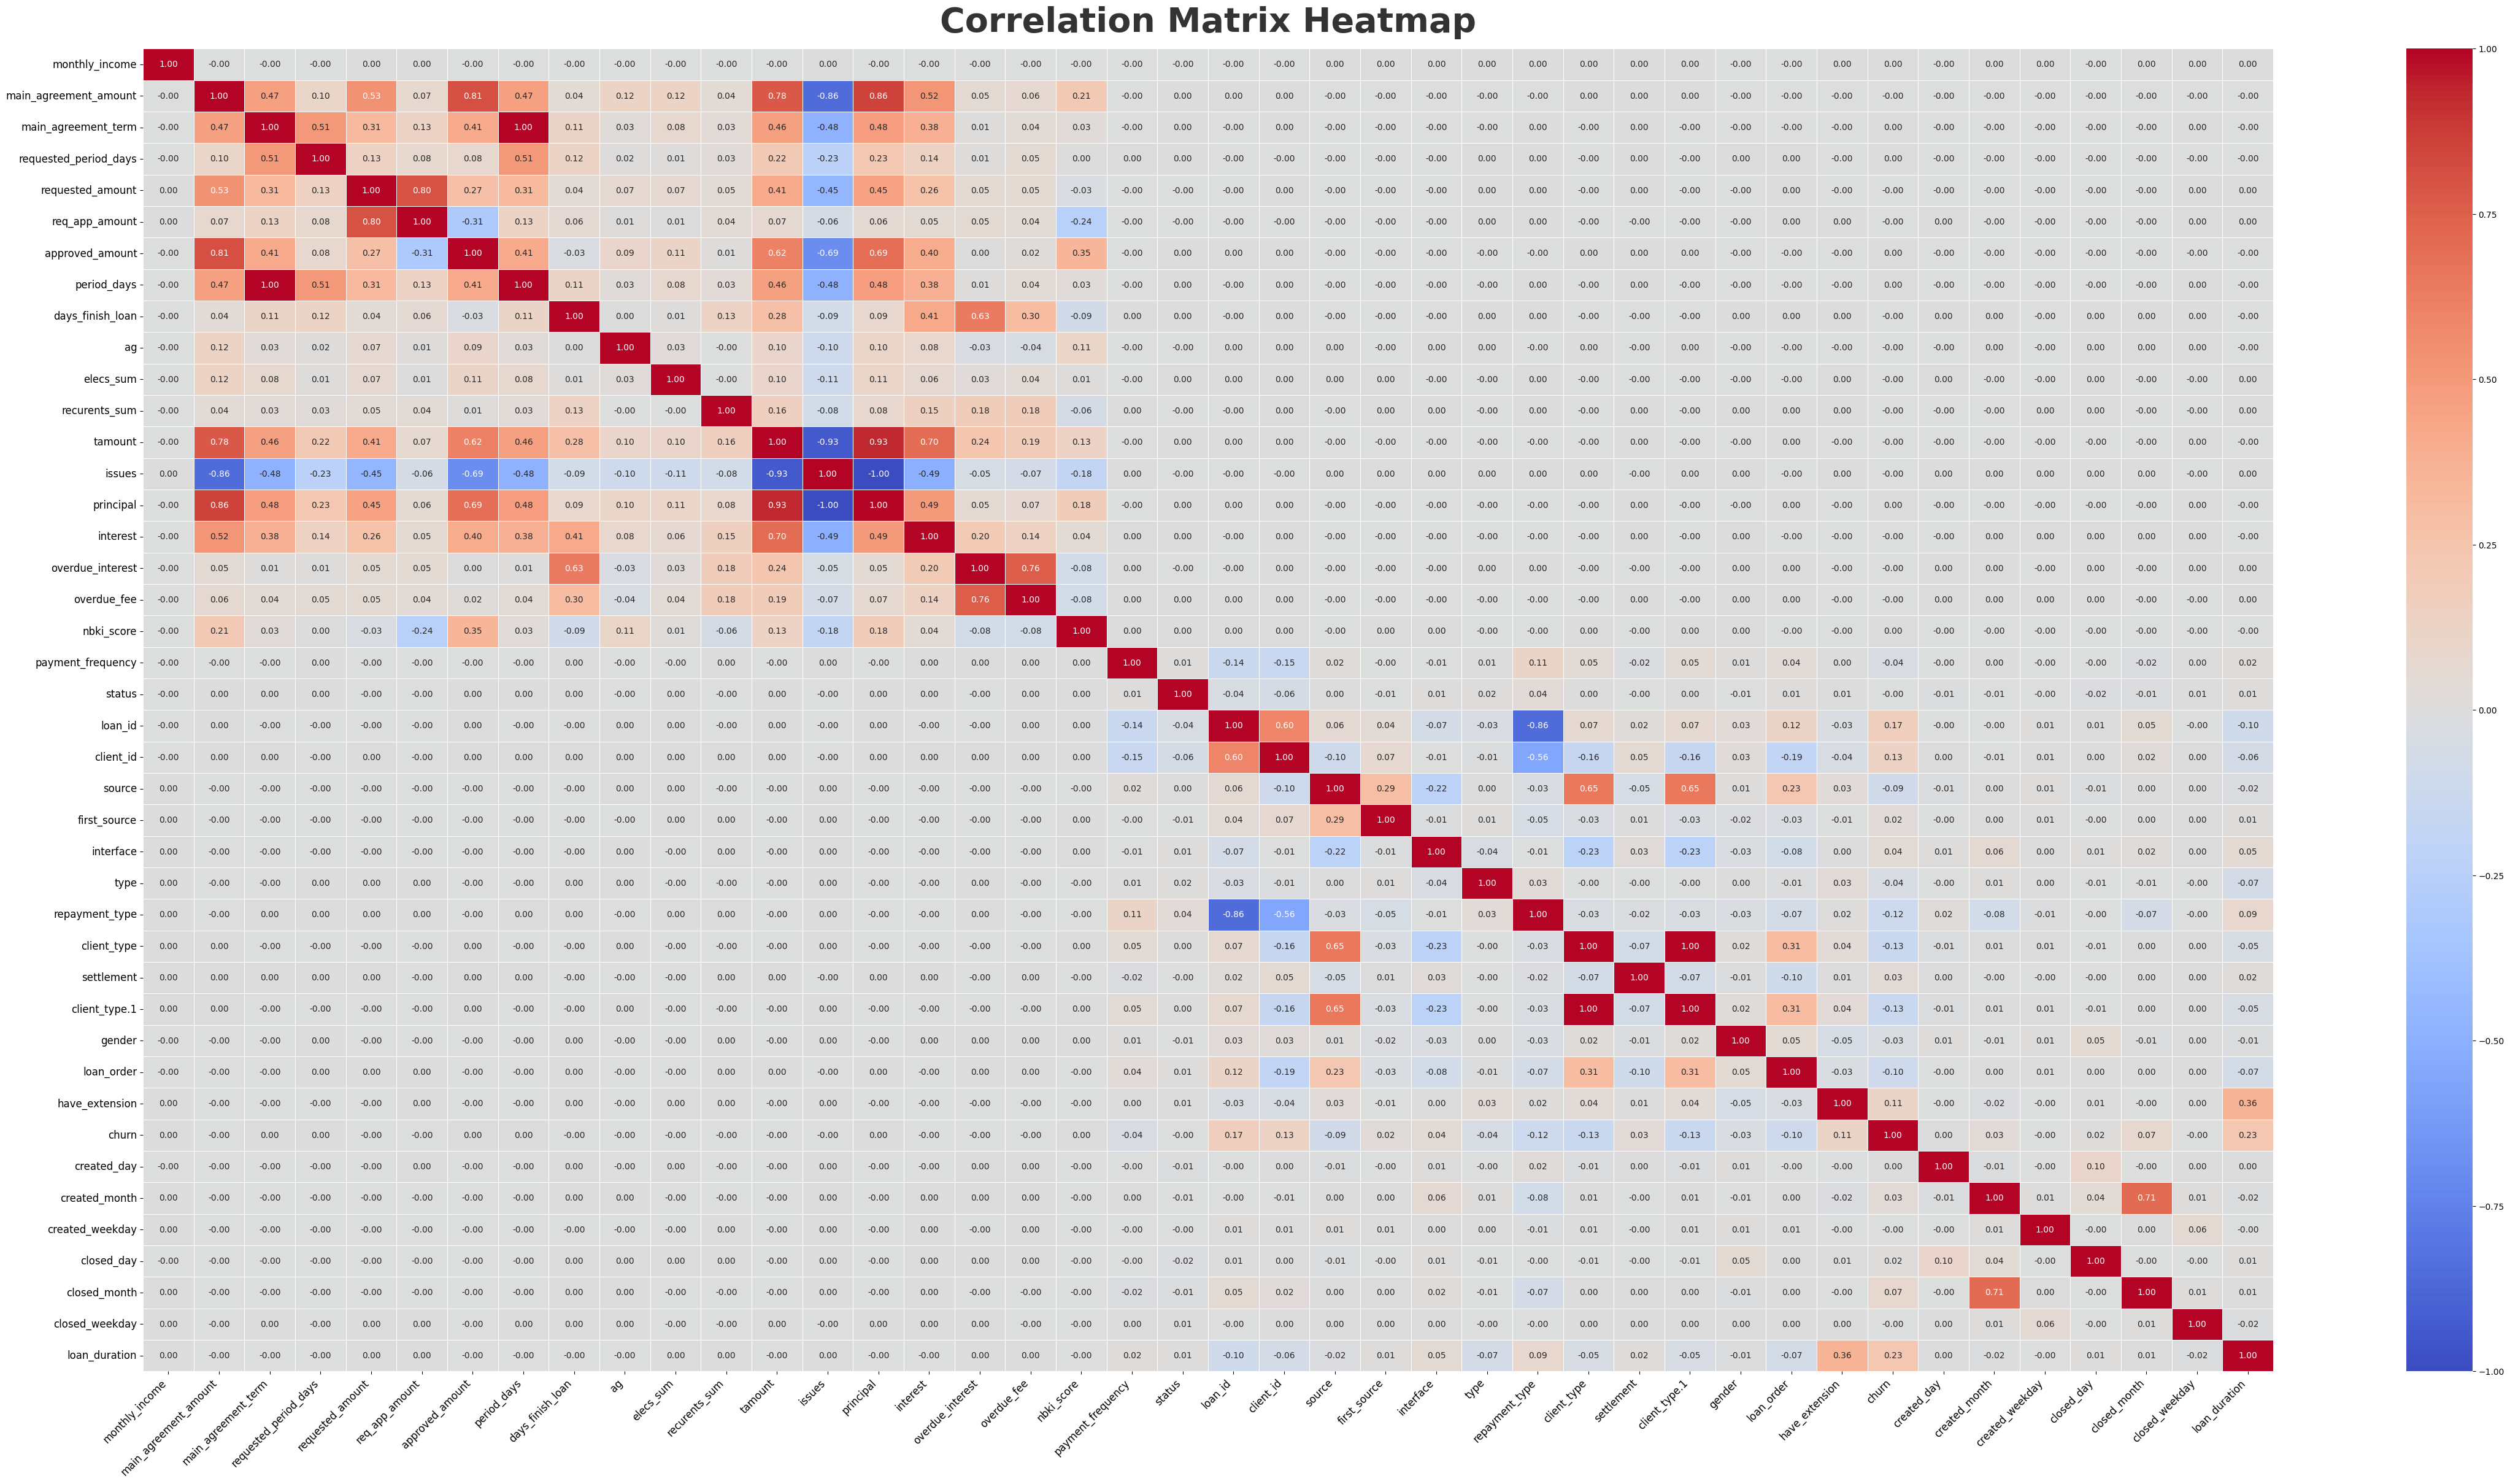

In [40]:
# создаем матрицу корреляций
correlation_matrix = train.corr()
# Создаём heatmap
plt.figure(figsize=(56, 28))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    linecolor="white"
)

# Настройки осей
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)

# Заголовок
plt.title("Correlation Matrix Heatmap", fontsize=40, weight='bold', color="#333333", pad=20)

# **Сохраняем картинку**
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches="tight")  # 300 DPI для качества

# Показываем график
plt.show()

Рассмотрев детальнее матрицу корреляций можно видеть:
- Отрицательные корреляции < -0.9:
  - issues - сумма просрочек, штрафов и пени и tamount - общий кэшфлоу клиента (общая сумма которая была на аккаунте клиента)
  - issues - сумма просрочек, штрафов и пени и tamount и principal - сумма основного долга и 
- Положительные корреляции > 0.9:
  - period_days - период страховки по займу и main_agreement_term - основной одобренный срок по займу
  - principal - сумма основного долга и tamount - общий кэшфлоу клиента (общая сумма которая была на аккаунте клиента)
  - client_type и client_type.1 - видать просто задвоили столбцы

Считаю, что необходимо избавиться от: ['period_days','principal','tamount', 'client_type.1']

In [44]:
# да, просто так кодировал признак собсна)))
sum(train['client_type'] == train['client_type.1'])

4036207

In [16]:
# Дропаем сильнокоррелирующие между собой столбцы
train.drop(axis=1, labels=['period_days','principal','tamount', 'client_type.1'], inplace=True)

##### Нормирование данных

Т.к. наши данные в различных единицах измерения, хорошо бы их привести к общей шкале измерений.
Но, поскольку мы будем пользоваться Бустингами, то нет необходимости это делать. Скипнем данный шаг.

##### Снижение размерностей

Данный шаг так же пока что пропущу, т.к. буду пробовать изначально бустинг)

### DataPreparating

Основная часть EDA была завершена, теперь необходимо:
- Повторить все манипуляции с тестовой частью;
- Подготовить данные;
- Приступить к обучению модели бустинга.

#### Подготовка test

In [23]:
test = pd.read_csv('./data/test.csv')

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 43 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   monthly_income         1348680 non-null  float64
 1   work_experience        463225 non-null   float64
 2   requested_sum          163790 non-null   float64
 3   main_agreement_amount  1348743 non-null  float64
 4   main_agreement_term    1348743 non-null  float64
 5   requested_period_days  1200882 non-null  float64
 6   requested_amount       1209772 non-null  float64
 7   req_app_amount         1209772 non-null  float64
 8   approved_amount        1348743 non-null  float64
 9   period_days            1348743 non-null  float64
 10  days_finish_loan       1348743 non-null  float64
 11  ag                     1348743 non-null  float64
 12  cnt_ext                151701 non-null   float64
 13  term                   151701 non-null   float64
 14  price             

In [22]:
# количество пропущенных значений по фичам:
test.isnull().sum()/len(test)*100

monthly_income           0.0
main_agreement_amount    0.0
main_agreement_term      0.0
requested_period_days    0.0
requested_amount         0.0
req_app_amount           0.0
approved_amount          0.0
period_days              0.0
days_finish_loan         0.0
ag                       0.0
elecs_sum                0.0
recurents_sum            0.0
tamount                  0.0
issues                   0.0
principal                0.0
interest                 0.0
overdue_interest         0.0
overdue_fee              0.0
nbki_score               0.0
payment_frequency        0.0
status                   0.0
loan_id                  0.0
client_id                0.0
source                   0.0
first_source             0.0
interface                0.0
type                     0.0
repayment_type           0.0
client_type              0.0
settlement               0.0
client_type.1            0.0
gender                   0.0
loan_order               0.0
have_extension           0.0
created_at    

In [ ]:
# === Загружаем данные ===
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# === Убираем признаки, которые есть в train, но отсутствуют в test ===
drop_cols = list(set(train.columns) - set(test.columns))
drop_cols.remove('churn')  # Не трогаем целевую переменную
print(f"Удаляем из train: {drop_cols}")
train.drop(columns=drop_cols, inplace=True)

# === Проверяем совпадение колонок ===
assert set(train.columns) - {'churn'} == set(test.columns), "Ошибка! Признаки не совпадают!"

# === Заполняем пропуски в test ===
for col in test.columns:
    if test[col].dtype == 'object':
        test[col].fillna('unknown', inplace=True)  # Для категориальных
    else:
        test[col].fillna(test[col].median(), inplace=True)  # Для числовых

# === Сохраняем подготовленные датасеты ===
train.to_csv('./data/train_prepared.csv', index=False)
test.to_csv('./data/test_prepared.csv', index=False)

print("✅ Данные подготовлены!")


In [19]:
# удаляем столбцы
test.drop(axis=1, labels=col_to_drop, inplace=True)
# заполняем все пропущенные значения средними, сгруппировав колонки по городу
test[col_to_change] = test.groupby('settlement')[col_to_change].transform(lambda x: x.fillna(x.mean()))
# Заполняем остатки
test[col_to_change] = test[col_to_change].fillna(test[col_to_change].mean())

In [20]:
# проверяем
test.isnull().sum()/len(test)*100

monthly_income           0.0
main_agreement_amount    0.0
main_agreement_term      0.0
requested_period_days    0.0
requested_amount         0.0
req_app_amount           0.0
approved_amount          0.0
period_days              0.0
days_finish_loan         0.0
ag                       0.0
elecs_sum                0.0
recurents_sum            0.0
tamount                  0.0
issues                   0.0
principal                0.0
interest                 0.0
overdue_interest         0.0
overdue_fee              0.0
nbki_score               0.0
payment_frequency        0.0
status                   0.0
loan_id                  0.0
client_id                0.0
source                   0.0
first_source             0.0
interface                0.0
type                     0.0
repayment_type           0.0
client_type              0.0
settlement               0.0
client_type.1            0.0
region                   0.0
gender                   0.0
loan_order               0.0
have_extension

In [21]:
# удаляем регион
test.drop(columns=['region'], inplace=True)
# кодируем бинарные признаки
label_enc_cols = ['client_type.1', 'gender']
for col in label_enc_cols:
    le = LabelEncoder()
    test[col] = le.fit_transform(test[col])

# Применяем обученный энкодер к test (без .fit!)
test['settlement'] = cat_enc.transform(test['settlement'])

# Если в test есть новые города, которых не было в train, CatBoostEncoder присвоит NaN.
# Чтобы этого избежать, можно заменить NaN на среднее значение кодировки из train:
mean_settlement = train['settlement'].mean()  
test['settlement'].fillna(mean_settlement, inplace=True)

# работа с датами
test['created_at'] = pd.to_datetime(test['created_at'])
test['closed_at'] = pd.to_datetime(test['closed_at'])

# День, месяц, год, день недели
test['created_day'] = test['created_at'].dt.day
test['created_month'] = test['created_at'].dt.month
test['created_weekday'] = test['created_at'].dt.weekday  # 0 = Понедельник, 6 = Воскресенье

test['closed_day'] = test['closed_at'].dt.day
test['closed_month'] = test['closed_at'].dt.month
test['closed_weekday'] = test['closed_at'].dt.weekday

# Длительность займа в днях
test['loan_duration'] = (test['closed_at'] - test['created_at']).dt.days

# Удаление изначальных столбцов
test.drop(columns=['created_at', 'closed_at'], inplace=True)

# взглянем на обновленные категориальные фичи!
cat_cols = ['settlement','client_type.1','gender', 'created_day','created_month','created_weekday','closed_day',
            'closed_month','closed_weekday','loan_duration']
test[cat_cols]

/tmp/ipykernel_15964/859729204.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['settlement'].fillna(mean_settlement, inplace=True)


KeyError: 'closed_at'

In [ ]:
# Дропаем сильнокоррелирующие между собой столбцы
test.drop(axis=1, labels=['period_days','principal','tamount', 'client_type.1'], inplace=True)

### TrainModel

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight

# === 1. Загружаем подготовленные данные ===
train = pd.read_csv('./data/train_prepared.csv')  # Уже подготовленный train
test = pd.read_csv('./data/test_prepared.csv')    # Уже подготовленный test

TARGET = 'churn'
FEATURES = [col for col in train.columns if col != TARGET]

X_train, X_val, y_train, y_val = train_test_split(
    train[FEATURES], train[TARGET], test_size=0.2, random_state=42, stratify=train[TARGET]
)

# === 2. Функция для поиска лучших параметров ===
def tune_model(model, param_grid):
    grid_search = GridSearchCV(
        model, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1
    )
    grid_search.fit(X_train, y_train, sample_weight=compute_sample_weight('balanced', y_train))
    print(f"🔹 Лучшие параметры: {grid_search.best_params_}")
    return grid_search.best_estimator_

# === 3. Подбираем параметры и обучаем XGBoost ===
xgb_params = {
    'n_estimators': [200, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = tune_model(xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"), xgb_params)
xgb_pred = xgb_model.predict(X_val)
print(f"✅ XGBoost F1-score: {f1_score(y_val, xgb_pred):.4f}")

# === 4. Подбираем параметры и обучаем LightGBM ===
lgb_params = {
    'n_estimators': [200, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
lgb_model = tune_model(lgb.LGBMClassifier(objective='binary'), lgb_params)
lgb_pred = lgb_model.predict(X_val)
print(f"✅ LightGBM F1-score: {f1_score(y_val, lgb_pred):.4f}")

# === 5. Подбираем параметры и обучаем CatBoost ===
cb_params = {
    'iterations': [200, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1]
}
cb_model = tune_model(cb.CatBoostClassifier(loss_function='Logloss', verbose=0), cb_params)
cb_pred = cb_model.predict(X_val)
print(f"✅ CatBoost F1-score: {f1_score(y_val, cb_pred):.4f}")

# === 6. Делаем предсказания на test.csv ===
xgb_test_pred = xgb_model.predict(test[FEATURES])
lgb_test_pred = lgb_model.predict(test[FEATURES])
cb_test_pred = cb_model.predict(test[FEATURES])

# === 7. Ансамбль: усредняем предсказания ===
final_pred = np.round((xgb_test_pred + lgb_test_pred + cb_test_pred) / 3).astype(int)

# === 8. Создаём submission.csv ===
submission = pd.DataFrame({'id': test.index, 'churn': final_pred})
submission.to_csv('submission.csv', index=False)

print("🚀 Submission сохранён в submission.csv! 🎯")


### Results